# Fanal, a neutrino-less beta decay experiment 

## An open exercise

##  Sentitivity of the experiment 

##  A Counting Experiment

### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata

February 2021 - February 2022


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD THE FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.confint as confint  # Confidence Intervals 
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective:

   * **Estimate the senstitivity as a counting experiment**

### Tasks

   * Estimate the expected 90 % $T^{0\nu}_\nu$ FC Confidence Intervals.
   
   * Estimate the range of $T^{0\nu}_{1/2}$ that will result in an observation


## Main parameters

In [5]:
coll          = collpars.collaboration
ntracks_range = collpars.ntracks_range
eblob2_range  = collpars.eblob2_range
erange        = collpars.erange
eroi          = collpars.eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : ({:d}, {:6.2f})'.format(*ntracks_range))
print('Blob-2 energy range       : ({:6.3f}, {:6.3f}) MeV'.format(*eblob2_range))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Collaboration             : new_beta
number of tracks range    : (1,   1.10)
Blob-2 energy range       : ( 0.400,  1.200) MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [6]:
# list of the selection variables names and ranges
varnames  = ['num_tracks', 'blob2_E', 'E', 'E']
varranges = [ntracks_range, eblob2_range, erange, eroi]
print('varnames  : ', varnames)
print('varranges : ', varranges)

varnames  :  ['num_tracks', 'blob2_E', 'E', 'E']
varranges :  [(1, 1.1), (0.4, 1.2), (2.4, 2.7), (2.43, 2.48)]


## Access the data

In [7]:
dirpath = '/Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

mcs      = [mcbb, mcbi, mctl]
tsamples = ['bb', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$',r'$^{214}$Bi', r'$^{208}$Tl']

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_new_beta.h5


## Total bkg in RoI


In [8]:
# number of  blind events
nevts_bkg_roi  = (collpars.nevts_Bi_RoI , collpars.nevts_Tl_RoI)
unevts_bkg_roi = (collpars.unevts_Bi_RoI, collpars.unevts_Tl_RoI)
nbkg_roi       = np.sum(nevts_bkg_roi)
unbkg_roi      = np.sqrt(np.sum([u**2 for u in unevts_bkg_roi]))
for i, name in enumerate(tsamples[1:]):
    print('Number of bkg events in RoI : {:s}  = {:6.2f} +- {:6.2f}.'.format(tsamples[i+1],
                                                                            nevts_bkg_roi[i], unevts_bkg_roi[i]))
print('Total Number of bkg events in RoI = {:6.2f} +- {:6.2f}.'.format(nbkg_roi, unbkg_roi))

Number of bkg events in RoI : Bi  =  21.75 +-   0.96.
Number of bkg events in RoI : Tl  =   4.01 +-   0.03.
Total Number of bkg events in RoI =  25.76 +-   0.96.


In [9]:
# number of  blind events
eff_roi   = np.array((collpars.eff_bb_RoI, collpars.eff_Bi_RoI , collpars.eff_Tl_RoI))
for i in range(len(mcs)):
    print('Efficiency in RoI : {:s}  = {:1.2e}.'.format(tsamples[i], eff_roi[i]))

Efficiency in RoI : bb  = 5.19e-01.
Efficiency in RoI : Bi  = 1.55e-02.
Efficiency in RoI : Tl  = 1.94e-04.


## Conficence Intervals

The frenquentist intervals are usually computed using the Feldman-Cousin construction.
  
The following code constract the confidence bands for a given number of background events and a range on the number of signal events.



**Exercise**:

  * Study how the CI changes depending on the observation
  
  * Study what is the value of observed events that will give an observation and a discovery.

In [10]:
nbkg   = nbkg_roi
n0     = int(nbkg)      # number of observed events (int)
cls    = (0.68, 0.9)    # range of CL to show
factor = 1.5
nbins  = 100
nus    = np.linspace(0., factor * nbkg, 100) # range of number of signal events

# get the FC-CI functions for 68% and 95% CL
fcs    = [confint.get_fc_confinterval(nus, nbkg, cl = cl) for cl in cls]

for fc, cl in zip(fcs, cls):
    ci = fc(n0)
    print('FC Cover Interval, observed n = {:d}, at {:2.0f} % CL = ({:4.2f}, {:4.2f})'.format(n0, 100*cl, *ci))

FC Cover Interval, observed n = 25, at 68 % CL = (0.00, 4.68)
FC Cover Interval, observed n = 25, at 90 % CL = (0.00, 8.59)


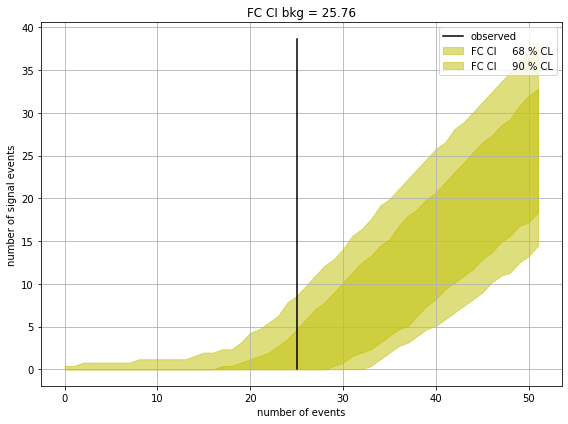

In [11]:
# plot the conficence band and the segment associated to an observation
pltext.canvas(1, 1, 6, 8)
ns   = np.arange(0, 2 * nbkg)
for fc, cl in zip(fcs, cls):    
    ys   = fc(ns)
    plt.fill_between(ns, *ys, alpha = 0.5, color = 'y', label = 'FC CI {:6.0f} % CL'.format(100*cl))
plt.plot(n0 * np.ones(len(nus)), nus, label = 'observed')
plt.legend(); plt.grid(which = 'both');
plt.title('FC CI bkg = {:4.2f}'.format(nbkg));
plt.xlabel('number of events'); plt.ylabel('number of signal events');
plt.tight_layout();

Translate the number of signal events into half-life time.

In [12]:
def tau(nbb):
    acc_bb   = collpars.acc_bb
    eff      = collpars.eff_bb_RoI
    exposure = collpars.exposure
    tau      = fn.half_life(nbb, exposure, acc_bb * eff)
    return tau

In [13]:
for fc, cl in zip(fcs, cls):
    ci   = fc(n0)
    taus = [tau(x) for x in ci]
    taus.reverse()
    print('FC Cover Interval, observed n = {:d}, at {:2.0f} % CL = ({:4.2e}, {:4.2e})'.format(n0, 100*cl, *taus))

FC Cover Interval, observed n = 25, at 68 % CL = (2.42e+26,  inf)
FC Cover Interval, observed n = 25, at 90 % CL = (1.32e+26,  inf)


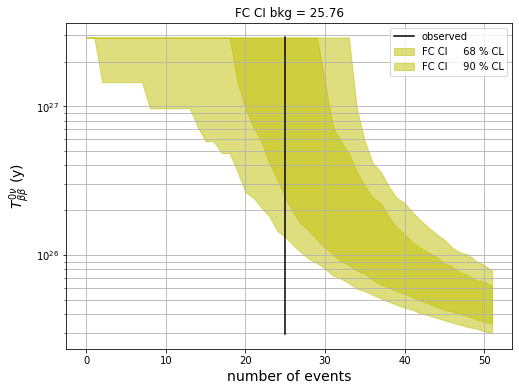

In [14]:
pltext.canvas(1, 1, 6, 8)
for fc, cl in zip(fcs, cls):    
    ys     = fc(ns)
    taus   = tau(ys)
    taus[taus == np.inf] = tau(nus[1])
    plt.fill_between(ns, *taus, 
                     alpha = 0.5, color = 'y', label = 'FC CI {:6.0f} % CL'.format(100*cl))
plt.plot(n0 * np.ones(len(nus)), tau(nus), label = 'observed')
plt.legend(); plt.grid(which = 'both');
plt.title('FC CI bkg = {:4.2f}'.format(nbkg));
plt.xlabel('number of events', fontsize = 14); plt.ylabel(r'$T^{0\nu}_{\beta\beta}$ (y)', fontsize = 14);
plt.yscale('log');
#plt.tight_layout();

## Compute p-value of null hypothesis

In [15]:
Z3    = 0.0027
Z5    = 2.87e-7
p0 = stats.poisson.sf(ns, nbkg) 

for z in (Z3, Z5):
    if (np.min(p0) < z):
        n1 = int(np.min(ns[p0<z]))
        print('p0-values < {:1.2e} if n > {:d}, Tbb < {:1.2e} y'.format(z, n1, tau(n1)))

p0-values < 2.70e-03 if n > 41, Tbb < 2.76e+25 y


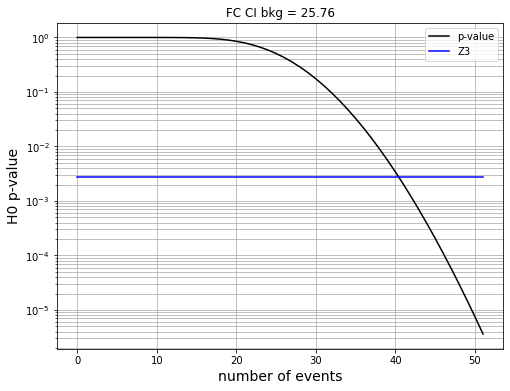

In [16]:
pltext.canvas(1, 1, 6, 8)
p0 = stats.poisson.sf(ns, nbkg) 
plt.plot(ns, p0, label = 'p-value')
plt.plot(ns, Z3 * np.ones(len(ns)), label = 'Z3')
plt.title('FC CI bkg = {:4.2f}'.format(nbkg));
plt.xlabel('number of events', fontsize = 14); plt.ylabel(r'H0 p-value', fontsize = 14);
plt.yscale('log'); plt.grid(which = 'both'); plt.legend();

## Hyppthesis testing, p-values and CLs

An alternative way is to compute the p-values for the null-hypothesis and the alternative hypothesis.

The alternative hypothesis is continuous, and depends on the $T^{0\nu}_{1/2}$

The following plots show:

  * the p-values of $H_1$ given the $H_0$ as true hypothesis,
  
  * the p-values of $H_0$ for the range of $H_\mu$
  
  * the CLs value for the range of $H_\mu$

**Exercise**:
    
  * Observe how the p-values and CLs values changes for different observations

In [17]:
n0    = nbkg_roi
cl    = 0.68
Z3    = 0.0027
Z5    = 2.87e-7
h0    = stats.poisson(nbkg_roi)
ci    = h0.interval(cl)
cis   = [ci[0], h0.median(), ci[1], n0] # values for the interval, median and observed
alpha = cl/2.
print('Expected number of bkg events in RoI = {:4.2f} +- {:4.2f}'.format(nbkg_roi, unbkg_roi))
print('Confidence Interval 68 % CL = ({:4.2f}, {:4.2f})'.format(cis[0], cis[1]))

Expected number of bkg events in RoI = 25.76 +- 0.96
Confidence Interval 68 % CL = (21.00, 26.00)


In [18]:
nus    = np.linspace(0., 1.5 * nbkg, 200)
taus   = tau(nus)
alphas = 0.5 - alpha, 0.5, 0.5 + alpha, h0.cdf(n0) 
p1s    = [stats.poisson(nbkg + nus).cdf(ci) for ci in cis]
cls    = [beta/(1-alpha) for beta, alpha in zip(p1s, alphas)]

In [19]:
xnus = stats.poisson.interval(cl, nbkg + nus)
xnus = (xnus[0], nbkg + nus, xnus[1], n0 + 0 * nus)
p0s  = [h0.sf(xnu) for xnu in xnus]

In [20]:
def _plot(xs, ps, zs = (), xlim = None, ylim = None, xlabel = '', ylabel = '', title = ''):
    plt.fill_between(xs, ps[0], ps[2], alpha = 0.6, color = 'y');
    plt.plot(xs, ps[1], label = 'expected');
    if (len(ps) == 4):
        plt.plot(xs, ps[3], ls = '--', label = 'observed');
    for z in zs:
        plt.plot(xs, z * np.ones(len(xs)));
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    if (xlim != None): plt.xlim(xlim)
    if (ylim != None): plt.ylim(ylim)
    plt.xscale('log'); plt.yscale('log')
    plt.grid(which= 'both');
    plt.legend()
    return    

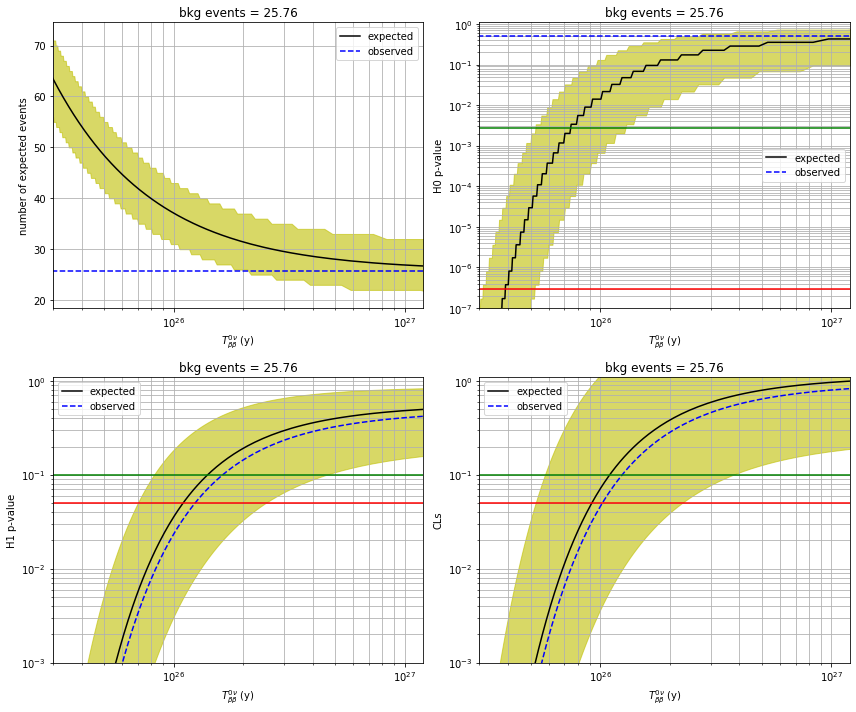

In [21]:
subplot = pltext.canvas(4, 2)
subplot(1)
title = 'bkg events = {:4.2f}'.format(nbkg_roi)
_plot(taus, xnus, xlim = (3.0e25, 1.2e27),
      xlabel = r'$T^{0\nu}_{\beta\beta}$ (y)', ylabel = r'number of expected events', title = title);
plt.yscale('linear')
subplot(2)
_plot(taus, p0s, (Z3, Z5), (3.0e25, 1.2e27), (1.0e-7, 1.1),
      r'$T^{0\nu}_{\beta\beta}$ (y)', 'H0 p-value', title = title);
subplot(3)
_plot(taus, p1s, (0.1, 0.05), (3.0e25, 1.2e27), (1.0e-3, 1.1),
      r'$T^{0\nu}_{\beta\beta}$ (y)', 'H1 p-value', title = title);
subplot(4)
_plot(taus, cls, (0.1, 0.05), (3.0e25, 1.2e27), (1.0e-3, 1.1),
      r'$T^{0\nu}_{\beta\beta}$ (y)', 'CLs', title = title);
plt.tight_layout();